## Markowitz Optimisation Problem and The Efficient Frontier

If we have a *portfolio* across the different stocks, investing a certain proportion $w_i$ in stock $i$ ($1 \leq i \leq n$). The values $w_i$ are called the *weights* of our portfolio. We write $\bf w$ for the vector of weights that determines the portfolio. We can have negative weights to indicate borrowing stock(short selling). We assume that the random vector $\bf r$ whose entries are given by returns of each stock $i$ follows a multivariate normal distribution with mean $\boldsymbol{\mu}$ and covariance matrix $\Sigma$. The return of our porfolio will be a random variable given by the weighted sum of all the returns in the portfolio
$$
r^{\text{portfolio}} = \sum_{i=1}^n r_i w_i = {\bf r}^\top {\bf w}.
$$

And the expected return of the portfolio is
$$
E(r^{\text{portfolio}}) = \sum_{i=1}^n \mu_i w_i = {\boldsymbol{\mu}}^\top {\bf w}.
$$
Markowitz model measures the risk of the portfolio using its variance.
$$
\begin{split}
\text{Var}(r^{\text{portfolio}})&={\bf w}^\top \Sigma {\bf w} 
\end{split}
$$
We wish to vary the weights to achieve a target expected return of $R$ while minimizing the variance.
A formal mathematical description of this problem can now be written as:
$$
\boxed{
\begin{array}{rcl}
\underset{{\bf w} \in {\mathbb R}^n}{\text{minimize}} & & {\bf w}^\top \Sigma {\bf w}\qquad \text{(minimize risk/variance)} \\
\text{subject to} & & {\bf 1}^\top {\bf w} = 1 \qquad \text{(Budget Constraint)} \\
\text{and} & & {\boldsymbol{\mu}}^\top {\bf w} = R \qquad \text{(Target Expected rate of Return Constraint)}
\end{array}}
$$

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import cvxopt
plt.rcParams['figure.figsize'] = [15,7]

ticker = ['BCS', 'HSBC', 'BAC', 'C', 'UBS', 'NWG', 'JPM', 'SAN', 'GS', 'MS',
          'LYG', 'BNP', 'WFC', 'USB', 'SCHW', 'BLK', 'DBK', 'MER', 'RY', 'NMR']

# Create an empty DataFrame to store the Weekly Stock Price Data.
stock_data = pd.DataFrame()

# Fetch and append weekly data for each stock to the DataFrame.
for tkr in ticker:
    stock = yf.download(tkr, start='2014-01-01', end='2023-01-01', interval='1wk', progress=False);
    stock = stock[['Adj Close']]  # Selecting only Adj Close column
    stock.columns = [tkr]  # Rename column to stock symbol
    stock_data = pd.concat([stock_data, stock], axis=1)

# Reset index to have a clean sequential index
stock_data.reset_index(inplace=True)

# Display the top 5 rows of dataframe.
print(stock_data.head())

        Date        BCS       HSBC        BAC          C        UBS       NWG  \
0 2014-01-01  13.709911  32.629074  13.637796  42.982121  14.381899  8.294806   
1 2014-01-08  14.311809  32.652561  13.860959  42.799652  15.248191  8.873849   
2 2014-01-15  13.880817  32.728909  14.059326  41.133678  15.196800  8.482993   
3 2014-01-22  13.613309  31.025805  13.827901  39.348709  14.954535  8.294806   
4 2014-01-29  12.951962  30.121403  13.513817  37.111549  14.947191  7.853284   

         JPM       SAN          GS  ...       LYG        BNP        WFC  \
0  44.114216  5.991158  147.934464  ...  3.847528  45.446999  34.010128   
1  43.961147  5.971684  146.532272  ...  4.024021  45.446999  34.152470   
2  44.288517  6.050050  143.711136  ...  3.967543  45.446999  34.834171   
3  42.438416  5.837536  137.944458  ...  3.918126  45.446999  34.429638   
4  41.836937  5.671507  134.218903  ...  3.755753  45.446999  33.538193   

         USB       SCHW         BLK  DBK  MER         RY   NMR

In [2]:
print(stock_data.shape)

# Dealing with missing values.
stock_data = stock_data.ffill()

# Check for remaining missing values after forward fill.
missing_values_count = stock_data.isnull().sum()
print("Remaining missing values after forward fill:\n", missing_values_count)

# Using backward fill to fill remaining values.
stock_data = stock_data.bfill()
missing_values_count = stock_data.isnull().sum()
print("Remaining missing values after backward fill:\n", missing_values_count)

(511, 21)
Remaining missing values after forward fill:
 Date      0
BCS       0
HSBC      0
BAC       0
C         0
UBS       0
NWG       0
JPM       0
SAN       0
GS        0
MS        0
LYG       0
BNP       0
WFC       0
USB       0
SCHW      0
BLK       0
DBK      43
MER     243
RY        0
NMR       0
dtype: int64
Remaining missing values after backward fill:
 Date    0
BCS     0
HSBC    0
BAC     0
C       0
UBS     0
NWG     0
JPM     0
SAN     0
GS      0
MS      0
LYG     0
BNP     0
WFC     0
USB     0
SCHW    0
BLK     0
DBK     0
MER     0
RY      0
NMR     0
dtype: int64


In [3]:
# Transforming into numpy arrays.
No_Weeks = stock_data.shape[0]
No_stocks = stock_data.shape[1]-1
price_history = np.zeros( [No_Weeks, No_stocks ] )
for i in range (0, No_Weeks):
    for j in range(0,No_stocks):
        row = No_Weeks-(i+1)
        col = j + 1
        price_history[i,j] = stock_data.iloc[row,col]
print(price_history.shape)
# Alternate code.
# # Convert stock_data to a NumPy array
# price_history = stock_data.iloc[:, 1:].to_numpy()

# # Reverse the order of rows in the NumPy array to have the correct chronological order
# price_history = price_history[::-1]

(511, 20)


In [4]:
print(price_history[:3,])
print(stock_data.tail(3))

[[  7.43248653  29.07149887  32.11990356  43.23311615  18.19239426
    6.0744977  130.21841431   2.83193612 332.83132935  81.84896851
    2.08320665  65.43000031  40.03697205  41.30477524  81.87471008
  693.36743164  13.24600029 388.79998779  90.13379669   3.75      ]
 [  7.44201517  28.98752975  31.54771805  42.4302063   18.16316223
    6.13091707 127.92671204   2.83193612 331.46459961  81.88747406
    2.13055229  65.43000031  39.79455566  41.34266281  80.85201263
  688.11309814  13.24600029 388.79998779  90.92948914   3.70000005]
 [  7.32766914  28.41841507  31.21798515  41.87581635  17.56876755
    6.03688478 126.90710449   2.83193612 333.90719604  81.98374939
    2.07373762  65.43000031  39.7363739   39.71357727  78.23625946
  676.66503906  13.24600029 388.79998779  89.79827118   3.6500001 ]]
          Date       BCS       HSBC        BAC          C        UBS  \
508 2022-12-14  7.327669  28.418415  31.217985  41.875816  17.568768   
509 2022-12-21  7.442015  28.987530  31.547718  

In [5]:
 stock_data.tail(3)

,Date,BCS,HSBC,BAC,C,UBS,NWG,JPM,SAN,GS,...,LYG,BNP,WFC,USB,SCHW,BLK,DBK,MER,RY,NMR
508,2022-12-14,7.327669,28.418415,31.217985,41.875816,17.568768,6.036885,126.907104,2.831936,333.907196,...,2.073738,65.43,39.736374,39.713577,78.236259,676.665039,13.246,388.799988,89.798271,3.65
509,2022-12-21,7.442015,28.987530,31.547718,42.430206,18.163162,6.130917,127.926712,2.831936,331.464600,...,2.130552,65.43,39.794556,41.342663,80.852013,688.113098,13.246,388.799988,90.929489,3.70
510,2022-12-28,7.432487,29.071499,32.119904,43.233116,18.192394,6.074498,130.218414,2.831936,332.831329,...,2.083207,65.43,40.036972,41.304775,81.874710,693.367432,13.246,388.799988,90.133797,3.75


In [6]:
# Computing Historical weekly returns.
start_prices = price_history[:-1,:]    # All prices except last row.
end_prices = price_history[1:,:]     # All prices except first row.
return_history = (end_prices-start_prices)/start_prices

In [7]:
# Computing Mean Returns and Return Covariance Matrix.
mu = np.mean( return_history, axis=0 )
print( mu.shape )
sigma = np.cov( return_history, rowvar=False )  # Covariance of columns same as axis=1.
print( sigma.shape )

(20,)
(20, 20)


## Plotting Risk and Expected Return.
Lets write a function that plots Risk(Standard Deviation) and Expected Return(R).

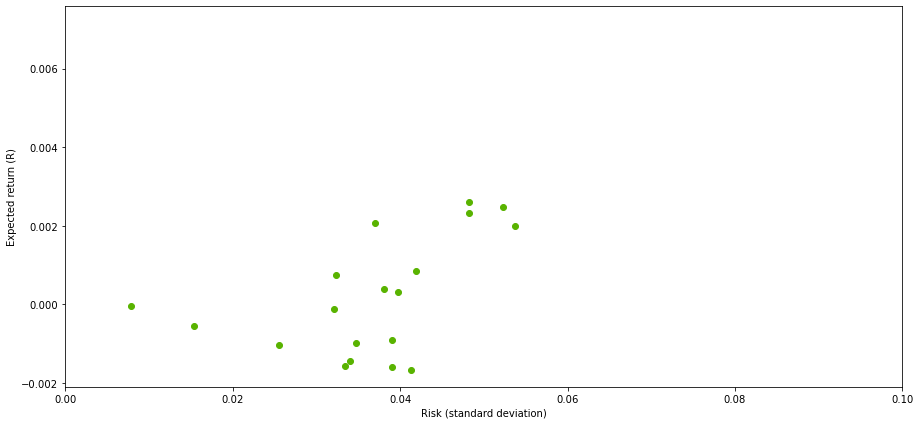

In [8]:
def plot_stock_points( sigma, mu):
    num_stocks = len(mu)
    sds = np.zeros( num_stocks )
    for i in range(0,num_stocks):
        sds[i] = np.sqrt(sigma[i,i]) # Diagonal entries of Cov Matrix gives Variance of each stock returns.

    ax = plt.gca()
    ax.scatter(sds,mu,c = '#59b300')
    ax.set_xlabel('Risk (standard deviation)')
    ax.set_ylabel('Expected return (R)');
    ax.set_xlim(0,0.1)

plot_stock_points(sigma,mu)

Markowitz Optimisation problem is a special case of a quadratic programming problem
$$
\boxed{
\begin{array}{rcl}
\underset{{\bf x} \in {\mathbb R}^n}{\text{minimize}} & & \frac{1}{2}{\bf x}^\top P {\bf x} + q^\top {\bf x} \\
\text{subject to} & & G {\bf x} \leq h \\
\text{and} & & A {\bf x} = b
\end{array}}
$$
Where $P$ is a positive definite symmetric $n\times n$ matrix, $q$ is a vector of length $n$, $G$ is a $k \times n$ matrix, $h$ is a $k$-vector, $A$ is an $\ell \times n$ matrix, $b$ is an $\ell$-vector.
If we compare Markowitz Optimisation problem to this general quadratic programming problem, we have
$P=\Sigma$,$q = 0$,$G=0$, $h=0$ and 
$$
A = 
\left(
    \begin{array}{c}
    {\bf 1}^\top \\
    \mu^\top
    \end{array}
\right), \qquad
b =
\left(
    \begin{array}{c}
    1 \\
    R
    \end{array}
\right)
$$
and write ${\bf w}$ instead of ${\bf x}$ then quadratic programming problem becomes the Markowitz problem.
We write $P=2 \Sigma$ since standard quadratic programming problem has $\frac{1}{2}{\bf x}^\top P {\bf x} + q^\top {\bf x}$.
We will solve this problem by using the library `cvxopt`. `cvxopt` has its own matrix data type and we must use `cvxopt.matrix` function to convert a `numpy` array into a `cvxopt` array. `cvxopt.qp` framework requires $P$ and $q$ as mandatory arguments in ${P,q,G,h,A,b}$. In Markowitz Optimisation problem, we only have equality constraints
$A{\bf x} = b$ and the inequality constraint is not there($G {\bf x} \leq h$). This library has its own matrix object defined column first. All arguments to `solvers.qp(P,q,G,h,A,b)` must be of this matrix type. The solvers also requires matrices with elements of type double/floats instead of integers.
We will write a function that takes inputs $\Sigma$(Returns Covariance Matrix), $\mu$(Mean Returns) and $R$(Target Expected Rate of Return) and solves the Markowitz optimization problem and returns the minimal standard deviation and the weights required to achieve this minimum.

In [9]:
def markowitz_solver( sigma, mu, R ):
    '''
    Solves Markowitz Optimisation problem and returns a dictionary containing optimal weights in
    Markowitz Problem and the minimum Standard Deviation(Risk) that is achieved.

            Parameters:
                    sigma (double) : Return Covariance Matrix.
                    mu (double) :  Mean Returns.
                    R (double) : Target Expected Rate of Returns.

            Returns:
                    ret (double): Dictionary containing two keys weights and Standard deviation (sd).
    '''
    n = len(mu)
    P = 2*sigma
    q = np.zeros(n)  # zero arrays.
    A = np.array([np.ones(n), mu])
    b = np.array([1,R]).T
    res = cvxopt.solvers.qp(
        cvxopt.matrix(P),
        cvxopt.matrix(q), # q
        None, # G
        None, # h
        cvxopt.matrix(A),
        cvxopt.matrix(b))  
     
    # Res is a map with keys, status, x and primal objective.
    status = res['status']
    assert status=="optimal"  # Checking if Optimisation succeeded.
    
    w = res['x']  # Optimal value of x/w in Quadratic/Markowitz problem.
    var = res['primal objective']  # Minimum Variance acheived.
    
    sd = np.sqrt(var)  # Minimum Standard Deviation(risk).
    # Creating Dictionary of weights and standard deviation.
    ret = {}
    ret['weights']=w
    ret['sd']=sd
    
    return ret

We will now plot `The Efficient Frontier` by going through a range of possible values for `R` and compute the corresponding minimal standard deviation and plot the graph. 

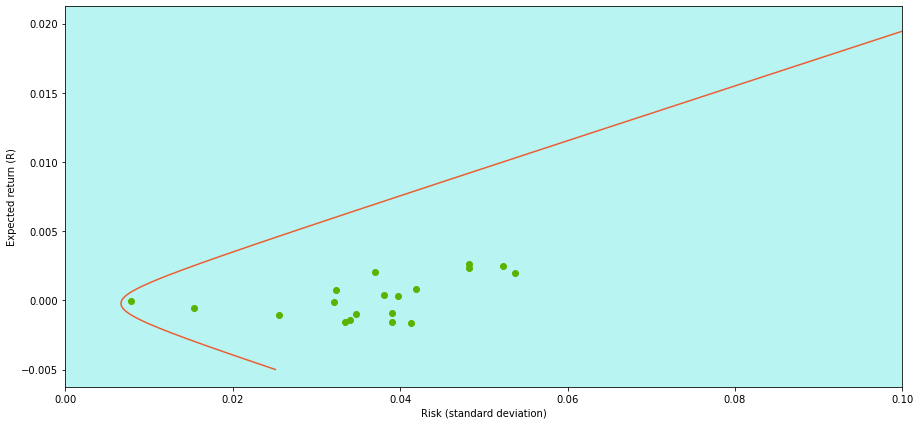

In [10]:
# Plotting The Efficient Frontier.
returns = np.linspace(-0.005,0.020,1000)
min_sds = np.zeros(1000)
for i in range(0,len(returns)):    
    ret = markowitz_solver(sigma, mu, returns[i])
    min_sds[i] = ret['sd']
    
ax = plt.gca()
ax.plot(min_sds,returns,c='#eb5e34');
ax.set_facecolor('#b8f5f2')

plot_stock_points(sigma, mu)

We observe from this plot that if the stock returns follow a multivariate normal distribution then any optimal investment portfolio will fall on the efficient frontier. This is because if asset returns follow a multivariate normal distribution, each portfolio will be normally distributed and so it's distribution is completely determined by it's mean return and it's standard deviation. If a portfolio doesn't lie on the efficient frontier, then we can improve it's expected return while minimizing it's risk by choosing the corresponding portfolio on the efficient frontier.

Lets now plot historic weekly return of the `Barclays` (Should be spiky and look like a graph of white noise) and try to simulate a sequence of normally distributed random numbers with the same mean and standard deviation as the returns of `Barclays`.

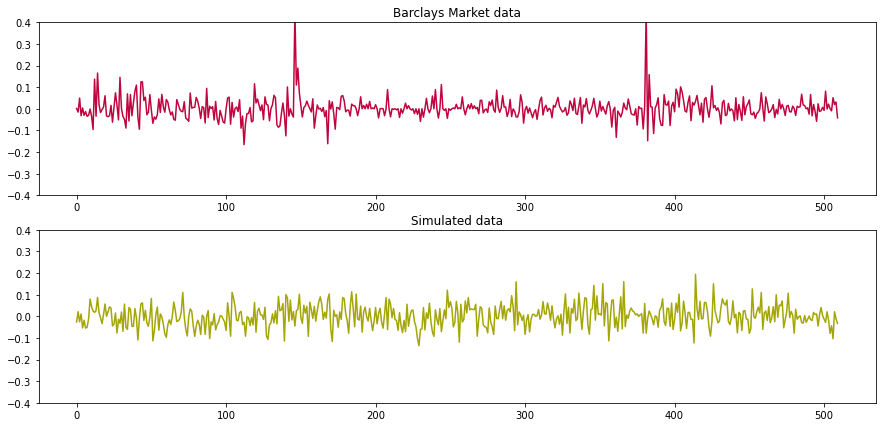

In [11]:
stock1_history = return_history[:,0]

mean = np.mean( stock1_history )
sd = np.std( stock1_history )

fig,[ax1,ax2]=plt.subplots(2,1)

weeks = np.arange(0,len( stock1_history) )
ax1.plot(weeks, stock1_history, label='Barclays Market data', c='#bf043f');
ax1.set_ylim(-0.4,0.4);
ax1.set_title('Barclays Market data')

simulated = np.random.randn(len(weeks))*sd + mean
ax2.plot(weeks, simulated, c='#a3a605');
ax2.set_ylim(-0.4,0.4);
ax2.set_title('Simulated data');

Lets Plot a `Quantile-Quantile Plot` to check for Normality of Barclays Stock Returns. This plot compares the quantiles of your data against the quantiles of a theoretical normal distribution. If the points fall approximately on a straight line, it suggests normality. For Normality, points should fall on straight line through first/third quartiles.

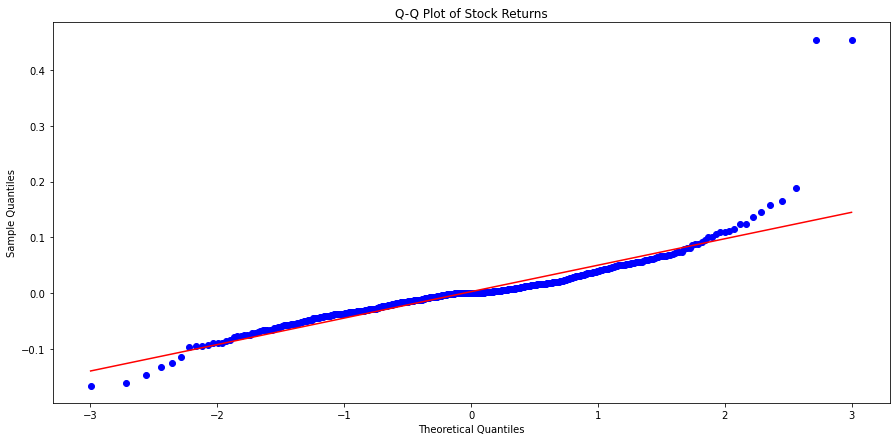

In [12]:
import scipy.stats as stats
Barclays_return = return_history[:,0]
# Quantile-Quantile Plot to check for Normality of Barclays Stock Returns.
stats.probplot(Barclays_return, dist="norm", plot=plt)
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.title('Q-Q Plot of Stock Returns')
plt.show()

Lets also plot the `Histogram and Density Plot of Barclays Stock Returns`. If it is Normally distributed then the data tends to form a bell-shaped curve around the mean.

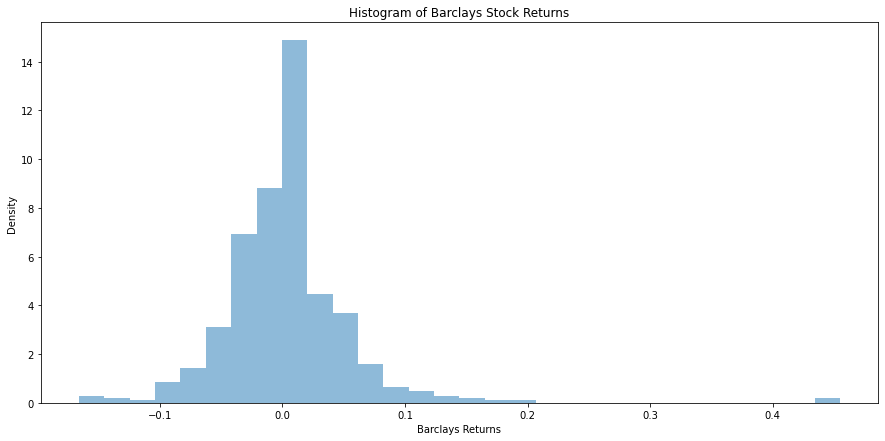

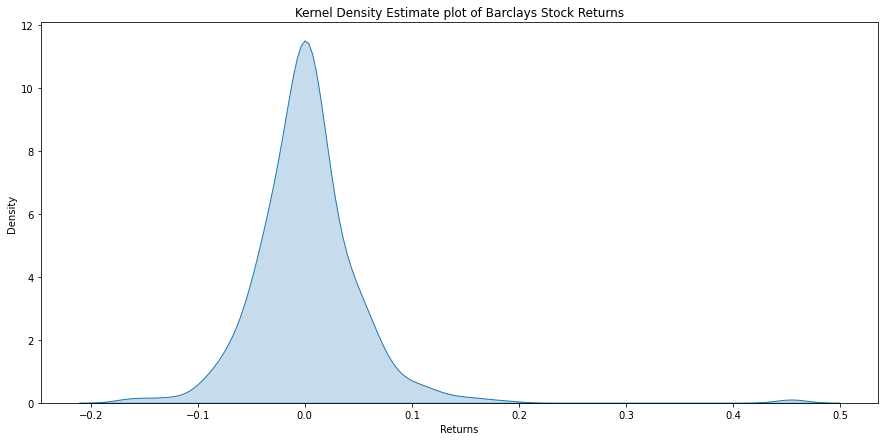

In [13]:
# Histogram of Stock returns.
plt.hist(Barclays_return, bins=30, density=True, alpha=0.5)
plt.xlabel('Barclays Returns')
plt.ylabel('Density')
plt.title('Histogram of Barclays Stock Returns')
plt.show()

# Density Plot.
plt.figure()
sns.kdeplot(Barclays_return, fill=True)
plt.xlabel('Returns')
plt.ylabel('Density')
plt.title('Kernel Density Estimate plot of Barclays Stock Returns')
plt.show()

We can also perform `Shapiro-Wilk test or Kolmogorov-Smirnov test` to formally check for normality. However, with large datasets, these tests might show significance even for minor deviations from normality.

In [14]:
# Shapiro-Wilk Test
stat, p = stats.shapiro(Barclays_return)
print(f'Shapiro-Wilk Test:\nStatistic: {stat}, p-value: {p}')
if p < 0.05:
    print("Shapiro-Wilk Test suggest Non-Normality")

# Kolmogorov-Smirnov Test
stat, p = stats.kstest(Barclays_return, 'norm')
print(f'Kolmogorov-Smirnov Test:\nStatistic: {stat}, p-value: {p}')
if p < 0.05:
    print("Kolmogorov-Smirnov Test suggest Non-Normality")

Shapiro-Wilk Test:
Statistic: 0.8256808519363403, p-value: 3.835632309979261e-23
Shapiro-Wilk Test suggest Non-Normality
Kolmogorov-Smirnov Test:
Statistic: 0.44999086186769993, p-value: 9.128691997626863e-95
Kolmogorov-Smirnov Test suggest Non-Normality


In [16]:
from scipy.stats import kurtosis, jarque_bera

# Calculate Kurtosis.
Barclays_kurtosis = kurtosis(Barclays_return)
print(f"Kurtosis: {Barclays_kurtosis}")

# Jarque-Bera test.
jb_stat, jb_p_value = jarque_bera(Barclays_return)
print(f"Jarque-Bera test statistic: {jb_stat}")
print(f"Jarque-Bera test p-value: {jb_p_value}")
alpha = 0.05  # Significance level
if jb_p_value < alpha:
    print("The data significantly deviates from a normal distribution.")
else:
    print("The data is consistent with a normal distribution.")

Kurtosis: 21.658726912685015
Jarque-Bera test statistic: 10552.966243183728
Jarque-Bera test p-value: 0.0
The data significantly deviates from a normal distribution.
